## 1. Definition of problem

In [1]:
#We define the number of correct responses on the 
I_s=[5, 10, 15, 20, 25, 30]
N_correct=[12,11,19,27,30,30]

In [2]:
P_guess=1/3
N_trials=30

## 2. Definition of pyshometric functions

In [3]:
from scipy.stats import norm

Model1:

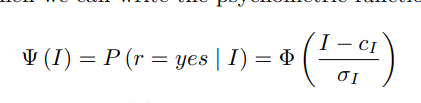

Model2: 

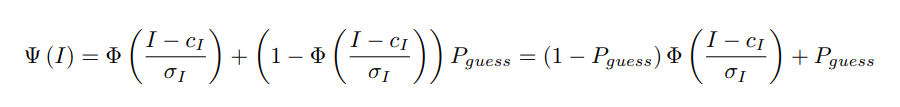

Model3: 

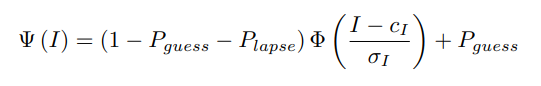

In [4]:
def model1(I, c, sigma):
    return norm.cdf((I-c)/sigma)

def model2(I, c, sigma, P_guess):
    return (1-P_guess)*model1(I,c,sigma)+P_guess

def model3(I, c, sigma, P_guess,P_lapse):
    return (1-P_guess-P_lapse)*model1(I,c,sigma)+P_guess

#### Log-likelihood function

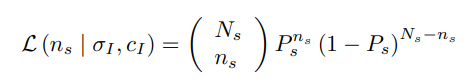

In [5]:
from scipy.stats import binom
def negative_log_likelihood(params, I, N_correct, N_s, function=1, P_guess = None):
    c, sigma = params[0],params[1]
    if function ==1 :
        probabilities = model1(I, c, sigma)
    elif function == 2:
        P_guess = P_guess
        probabilities = model2(I, c, sigma, P_guess)
    elif function == 3:
        P_guess = P_guess
        P_lapse=params[2]
        probabilities = model3(I, c, sigma, P_guess, P_lapse)
    else:
        raise ValueError("Invalid function name. Supported functions: 'psycometric_1', 'psycometric_2', 'psycometric_3'")

    log_likelihood = sum([binom.logpmf(N, N_s, p) for N, p in zip(N_correct, probabilities)])   # We can see the likelihood of a point as how possible is to have a value given a function with theirs parameters. In this case, the likelihood of each point can be calculated using a binomial distribution. Then to see the likelihood of all the 6 points of the intensity of the stimulus, we should multiply their likelihood because we consider them i.i.d points, however we are using the log-likelihood so we can sum their logarithms.
    return -log_likelihood

## 3. Fit of the models

In [6]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Realizamos el fit del modelo 

RECORDAR SIEMPRE QUE N_CORRECT ESTÁ EN NÚMERO ABSOLUTO DE RESPUESTAS SEGÚN ESTA FUNCIÓN DE LOG LIKELIHOOD DEFINIDA

In [7]:
c_initial_guess = max(I_s)/2   
sigma_initial_guess = max(I_s)/3
initial_guess = [c_initial_guess, sigma_initial_guess]

# We optimize the negative log likelihood function
optimized_parameters = minimize(negative_log_likelihood, initial_guess, args=(I_s, N_correct, N_trials,1))   #We optimize using minimize function from scipy library
c1_optimized, sigma1_optimized = optimized_parameters.x

print(f'Valor óptimo de c en modelo 1: {c1_optimized:.3f}')
print(f'Valor óptimo de sigma en modelo 1: {sigma1_optimized:.3f}')

Valor óptimo de c en modelo 1: 10.132
Valor óptimo de sigma en modelo 1: 8.191


In [8]:
c_initial_guess = max(I_s)/2   
sigma_initial_guess = max(I_s)/3
initial_guess = [c_initial_guess, sigma_initial_guess]

# We optimize the negative log likelihood function
optimized_parameters = minimize(negative_log_likelihood, initial_guess, args=(I_s, N_correct, N_trials,2, P_guess))   #We optimize using minimize function from scipy library
c2_optimized, sigma2_optimized = optimized_parameters.x

print(f'Valor óptimo de c en modelo 2: {c2_optimized:.3f}')
print(f'Valor óptimo de sigma en modelo 2: {sigma2_optimized:.3f}')

Valor óptimo de c en modelo 2: 15.692
Valor óptimo de sigma en modelo 2: 3.778


In [9]:
# Model 3
# We optimize the negative log likelihood function

# Define the constraint for P_lapse between 0 and 1
bnds = ((-np.inf, np.inf), (-np.inf, np.inf),(0,1))
P_lapse_initial_guess=0.05
initial_guess=[c_initial_guess, sigma_initial_guess, P_lapse_initial_guess]
optimized_parameters = minimize(negative_log_likelihood, initial_guess, args=(I_s, N_correct, N_trials, 3, P_guess), bounds=bnds)   #We optimize using minimize function from scipy library
c3_optimized, sigma3_optimized, P_lapse3_optimized = optimized_parameters.x

print(f'Valor óptimo de c en modelo 3: {c3_optimized:.3f}')
print(f'Valor óptimo de sigma en modelo 3: {sigma3_optimized:.3f}')
print(f'Valor óptimo de P_lapse en modelo 3: {P_lapse3_optimized}')

Valor óptimo de c en modelo 3: 15.692
Valor óptimo de sigma en modelo 3: 3.778
Valor óptimo de P_lapse en modelo 3: 0.0


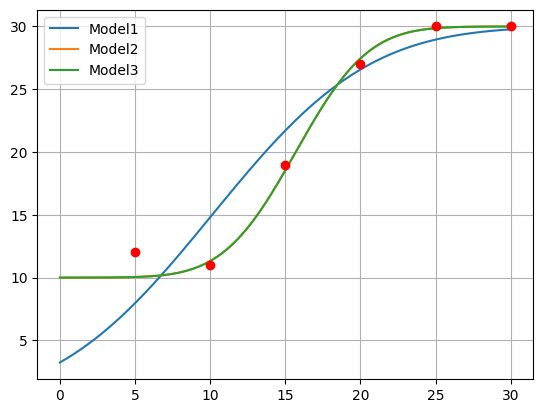

In [17]:
pyscho1=[]
pyscho2=[]
pyscho3=[]
x=np.linspace(0,max(I_s), 5000)
for i in x:
    pyscho1.append(N_trials*model1(i,c1_optimized,sigma1_optimized))
    pyscho2.append(N_trials*model2(i,c2_optimized,sigma2_optimized,P_guess))
    pyscho3.append(N_trials*model3(i,c3_optimized,sigma3_optimized, P_guess, P_lapse3_optimized))

plt.plot(x, pyscho1, label="Model1")
plt.plot(x, pyscho2, label="Model2")
plt.plot(x, pyscho3, label="Model3")
plt.plot(I_s, N_correct, 'ro')
plt.legend()
plt.grid()
plt.show()

#Model 3 and Model 2 almost equal that is why we don't see the prange curve

# 4. List negative log-likelihood

In [18]:
from tabulate import tabulate

In [19]:
NLL1= negative_log_likelihood((c1_optimized, sigma1_optimized), I_s, N_correct, N_trials, function=1, P_guess = None)
NLL2= negative_log_likelihood((c2_optimized, sigma2_optimized), I_s, N_correct, N_trials, function=2, P_guess = P_guess)
NLL3= negative_log_likelihood((c3_optimized, sigma3_optimized, P_lapse3_optimized), I_s, N_correct, N_trials, function=3, P_guess = P_guess)

NLL_list=[NLL1,NLL2, NLL3]
names=["Model 1", "Model 2", "Model 3"]
data=list(zip(names, NLL_list))
print(tabulate(data, headers=["Model", "NLL"]))

Model         NLL
-------  --------
Model 1  11.3153
Model 2   7.63735
Model 3   7.63735


# 5. Evaluation with Akaike information

In [20]:
Np=[2,2,3]
AIC_list=[2*(Np[i]+NLL_list[i]) for i in range(3)]
data=list(zip(names, AIC_list))
print(tabulate(data, headers=["Model", "AIC"]))

Model        AIC
-------  -------
Model 1  26.6307
Model 2  19.2747
Model 3  21.2747


# 6. Nc=29 for Is=30

In [21]:
#We define the number of correct responses on the 
I_s=[5, 10, 15, 20, 25, 30]
N_correct=[12,11,19,27,30,29]
P_guess=1/3
N_trials=30

In [22]:
c_initial_guess = max(I_s)/2   
sigma_initial_guess = max(I_s)/3
initial_guess = [c_initial_guess, sigma_initial_guess]

# We optimize the negative log likelihood function
optimized_parameters = minimize(negative_log_likelihood, initial_guess, args=(I_s, N_correct, N_trials,1))   #We optimize using minimize function from scipy library
c1_optimized, sigma1_optimized = optimized_parameters.x

print(f'Valor óptimo de c en modelo 1: {c1_optimized:.3f}')
print(f'Valor óptimo de sigma en modelo 1: {sigma1_optimized:.3f}')

Valor óptimo de c en modelo 1: 10.087
Valor óptimo de sigma en modelo 1: 9.185


In [23]:
c_initial_guess = max(I_s)/2   
sigma_initial_guess = max(I_s)/3
initial_guess = [c_initial_guess, sigma_initial_guess]

# We optimize the negative log likelihood function
optimized_parameters = minimize(negative_log_likelihood, initial_guess, args=(I_s, N_correct, N_trials,2, P_guess))   #We optimize using minimize function from scipy library
c2_optimized, sigma2_optimized = optimized_parameters.x

print(f'Valor óptimo de c en modelo 2: {c2_optimized:.3f}')
print(f'Valor óptimo de sigma en modelo 2: {sigma2_optimized:.3f}')

Valor óptimo de c en modelo 2: 15.481
Valor óptimo de sigma en modelo 2: 5.788


In [24]:
# Model 3
# We optimize the negative log likelihood function

# Define the constraint for P_lapse between 0 and 1
bnds = ((-np.inf, np.inf), (-np.inf, np.inf),(0,1))
P_lapse_initial_guess=0.05
initial_guess=[c_initial_guess, sigma_initial_guess, P_lapse_initial_guess]
optimized_parameters = minimize(negative_log_likelihood, initial_guess, args=(I_s, N_correct, N_trials, 3, P_guess), bounds=bnds)   #We optimize using minimize function from scipy library
c3_optimized, sigma3_optimized, P_lapse3_optimized = optimized_parameters.x

print(f'Valor óptimo de c en modelo 3: {c3_optimized:}')
print(f'Valor óptimo de sigma en modelo 3: {sigma3_optimized:}')
print(f'Valor óptimo de P_lapse en modelo 3: {P_lapse3_optimized}')

Valor óptimo de c en modelo 3: 15.495973353129855
Valor óptimo de sigma en modelo 3: 3.643150749122693
Valor óptimo de P_lapse en modelo 3: 0.017672691702726655


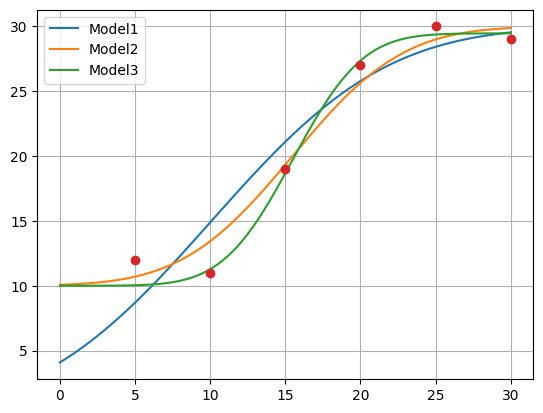

In [25]:
pyscho1=[]
pyscho2=[]
pyscho3=[]
x=np.linspace(0,max(I_s), 5000)
for i in x:
    pyscho1.append(N_trials*model1(i,c1_optimized,sigma1_optimized))
    pyscho2.append(N_trials*model2(i,c2_optimized,sigma2_optimized,P_guess))
    pyscho3.append(N_trials*model3(i,c3_optimized,sigma3_optimized, P_guess, P_lapse3_optimized))

plt.plot(x, pyscho1, label="Model1")
plt.plot(x, pyscho2, label="Model2")
plt.plot(x, pyscho3, label="Model3")
plt.plot(I_s, N_correct, 'o')
plt.legend()
plt.grid()
plt.show()

In [26]:
NLL1= negative_log_likelihood((c1_optimized, sigma1_optimized), I_s, N_correct, N_trials, function=1, P_guess = None)
NLL2= negative_log_likelihood((c2_optimized, sigma2_optimized), I_s, N_correct, N_trials, function=2, P_guess = P_guess)
NLL3= negative_log_likelihood((c3_optimized, sigma3_optimized, P_lapse3_optimized), I_s, N_correct, N_trials, function=3, P_guess = P_guess)

NLL_list=[NLL1,NLL2, NLL3]
names=["Model 1", "Model 2", "Model 3"]
data=list(zip(names, NLL_list))
print(tabulate(data, headers=["Model", "NLL"]))

Model         NLL
-------  --------
Model 1  12.4123
Model 2  11.206
Model 3   9.25101


In [27]:
Np=[2,2,3]
AIC_list=[2*(Np[i]+NLL_list[i]) for i in range(3)]
data=list(zip(names, AIC_list))
print(tabulate(data, headers=["Model", "AIC"]))

Model        AIC
-------  -------
Model 1  28.8245
Model 2  26.4119
Model 3  24.502


### Conclusion:
As for the maximum stimulus we edit a 29/30 correct answer, a lapse probability is introduced, so the model 3 fits better than the second.